# Machine Learning Capstone Project

Fist we have to import the dependecies needed for the project as specified by the [README](https://github.com/jeyvison/machine_learning_project/blob/master/README.md) file

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from IPython.display import display 
from sklearn.feature_selection import RFECV
import visuals as vs
from sklearn.metrics import f1_score
from sklearn.metrics import  make_scorer
from sklearn.dummy import DummyClassifier

# Pretty display for notebooks
%matplotlib inline

print 'Dependencies succefully imported'

Dependencies succefully imported


In [12]:
#Loading the trainning data
data = pd.read_csv('data.csv')

#Removing unnecessary id column
data.drop(['id'],1,inplace=True)

# Extract feature columns
feature_cols = list(data.columns[1:])

# Extract target column 'diagnosis'
target_col = data.columns[0] 

X = data[feature_cols]
y = data[target_col]

print 'Dataset succefully loaded. {0} points and {1} features'.format(*X.shape)

print X.head()

Dataset succefully loaded. 548 points and 30 features
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean           ..

Since we are in a high dimensional feature space we must check which features have more importance on this dataset so we can performe a feature reduction.

In [13]:
#First, we scale the dataset with the log function
X = np.log(X)

#We had some 0 values in our dataset that were turned to 'inf'
#Now we have to change it back
X[np.isinf(X)] = 0.0


display(X.describe())

/home/jeyvison/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,...,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,2.621729,2.924086,4.491953,6.368539,-2.347557,-2.376077,-2.800032,-3.258605,-1.717119,-2.773172,...,2.752916,3.207844,4.634624,6.622714,-2.033641,-1.542540,-1.604429,-2.278764,-1.253752,-2.496106
std,0.235473,0.215632,0.247846,0.477665,0.143816,0.490923,1.125278,0.945565,0.146783,0.107827,...,0.274172,0.238201,0.287709,0.550523,0.173135,0.610332,0.991730,0.697587,0.198052,0.195295
min,1.943192,2.273156,3.779405,4.966335,-2.772429,-3.943514,-7.275925,-6.291489,-2.148149,-2.996533,...,2.070653,2.486572,3.920190,5.221436,-2.642684,-3.601235,-6.295276,-4.736190,-1.854699,-2.899695
25%,2.463640,2.776331,4.324199,6.053027,-2.445273,-2.723039,-3.470065,-3.860737,-1.816771,-2.851199,...,2.569554,3.040227,4.436515,6.250023,-2.144941,-1.909868,-2.088289,-2.695702,-1.377930,-2.633279
50%,2.595255,2.926918,4.460664,6.315267,-2.343043,-2.364098,-2.711532,-3.339644,-1.715632,-2.787987,...,2.706716,3.227241,4.583538,6.533934,-2.027988,-1.532015,-1.431710,-2.263376,-1.263369,-2.523980
75%,2.759850,3.070144,4.645832,6.664595,-2.249993,-2.036382,-1.992715,-2.556897,-1.631172,-2.714848,...,2.933591,3.375965,4.829712,6.989334,-1.921242,-1.074115,-0.928302,-1.783958,-1.143035,-2.384663
max,3.336125,3.670715,5.239098,7.824446,-1.811554,-1.063052,0.000000,0.000000,-1.190728,-2.328518,...,3.584629,3.902780,5.526249,8.355615,-1.502379,0.056380,0.224742,0.000000,-0.409774,-1.572624


Now that we scaled the data lets analyze it

In [14]:
svc = SVC(kernel="linear",random_state=52,probability=True)

stratifiedKFold = StratifiedKFold(n_splits=10,shuffle=True,random_state=30)

rfecv = RFECV(estimator=svc, step=1, cv=stratifiedKFold,
              scoring=make_scorer(f1_score,pos_label='B'),verbose=False)

new_X = rfecv.fit_transform(X,y)

print 'Features selected'

Features selected


Now that we have

Optimal number of features : 18


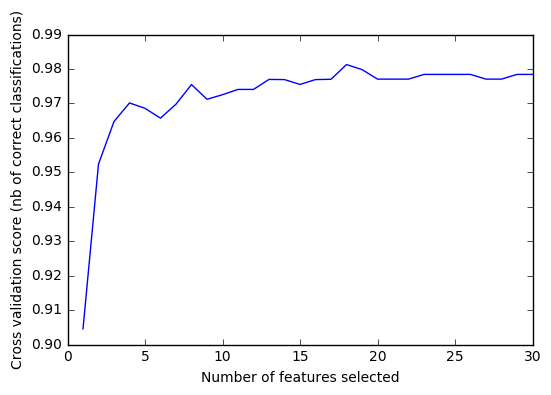

Max score found:0.9812667066


In [15]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print 'Max score found:' +  str(max(rfecv.grid_scores_))


Now we reduced our data we must find the best score for the possible component numbers.

In [16]:
#For benchmarking purposes, we should fit a Dummy classifier too, for comparisons a posteriori
dummy_clf = DummyClassifier()

for train_index,test_index in stratifiedKFold.split(new_X, y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
    svc.fit(X_train,y_train)
    print svc.score(X_test,y_test)
    dummy_clf.fit(X_train,y_train)
    print dummy_clf.score(X_test,y_test)

0.964285714286
0.553571428571
0.964285714286
0.482142857143
0.981818181818
0.581818181818
0.963636363636
0.490909090909
0.981818181818
0.6
0.981818181818
0.490909090909
1.0
0.481481481481
1.0
0.537037037037
0.981481481481
0.648148148148
0.944444444444
0.5


Now that we trainned our model we may load the evaluation file 

In [20]:
#Loading the evaluation data
evaluation_data = pd.read_csv('evaluation_data.csv')

#Removing unnecessary id column
evaluation_data.drop(['id','diagnosis'],1,inplace=True)

# Extract feature columns
feature_cols = list(evaluation_data.columns[0:])

X_evaluation = evaluation_data[feature_cols]

print 'Evaluation dataset succefully loaded. {0} points and {1} features'.format(*X_evaluation.shape)

Evaluation dataset succefully loaded. 29 points and 30 features


Since SVM is sensitve to feature scaling, we must scale our feature data before use SVC

In [21]:
#First, we scale the dataset with the log function
X_evaluation = np.log(X_evaluation)

#We had some 0 values in our dataset that were turned to 'inf'
#Now we have to change it back
X_evaluation[np.isinf(X_evaluation)] = 0.0
X_evaluation[np.isnan(X_evaluation)] = 0.0

display(X.describe())

X_evaluation = rfecv.transform(X_evaluation)

/home/jeyvison/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,...,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,2.621729,2.924086,4.491953,6.368539,-2.347557,-2.376077,-2.800032,-3.258605,-1.717119,-2.773172,...,2.752916,3.207844,4.634624,6.622714,-2.033641,-1.542540,-1.604429,-2.278764,-1.253752,-2.496106
std,0.235473,0.215632,0.247846,0.477665,0.143816,0.490923,1.125278,0.945565,0.146783,0.107827,...,0.274172,0.238201,0.287709,0.550523,0.173135,0.610332,0.991730,0.697587,0.198052,0.195295
min,1.943192,2.273156,3.779405,4.966335,-2.772429,-3.943514,-7.275925,-6.291489,-2.148149,-2.996533,...,2.070653,2.486572,3.920190,5.221436,-2.642684,-3.601235,-6.295276,-4.736190,-1.854699,-2.899695
25%,2.463640,2.776331,4.324199,6.053027,-2.445273,-2.723039,-3.470065,-3.860737,-1.816771,-2.851199,...,2.569554,3.040227,4.436515,6.250023,-2.144941,-1.909868,-2.088289,-2.695702,-1.377930,-2.633279
50%,2.595255,2.926918,4.460664,6.315267,-2.343043,-2.364098,-2.711532,-3.339644,-1.715632,-2.787987,...,2.706716,3.227241,4.583538,6.533934,-2.027988,-1.532015,-1.431710,-2.263376,-1.263369,-2.523980
75%,2.759850,3.070144,4.645832,6.664595,-2.249993,-2.036382,-1.992715,-2.556897,-1.631172,-2.714848,...,2.933591,3.375965,4.829712,6.989334,-1.921242,-1.074115,-0.928302,-1.783958,-1.143035,-2.384663
max,3.336125,3.670715,5.239098,7.824446,-1.811554,-1.063052,0.000000,0.000000,-1.190728,-2.328518,...,3.584629,3.902780,5.526249,8.355615,-1.502379,0.056380,0.224742,0.000000,-0.409774,-1.572624


Now that we scalled our data lets predict it

In [25]:
print svc.predict(X_evaluation)
print svc.predict_proba(X_evaluation)
print dummy_clf.predict(X_evaluation)
print dummy_clf.predict_proba(X_evaluation)

['B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'M' 'M'
 'M' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B']
[[  9.99996114e-01   3.88596461e-06]
 [  9.99270399e-01   7.29600624e-04]
 [  9.98022461e-01   1.97753910e-03]
 [  9.99860803e-01   1.39197021e-04]
 [  9.81996962e-01   1.80030381e-02]
 [  9.99999565e-01   4.35342597e-07]
 [  8.82801040e-01   1.17198960e-01]
 [  9.98571312e-01   1.42868779e-03]
 [  9.99999689e-01   3.11418290e-07]
 [  9.89035431e-01   1.09645692e-02]
 [  9.74531226e-01   2.54687742e-02]
 [  9.60183416e-01   3.98165835e-02]
 [  7.60865269e-01   2.39134731e-01]
 [  9.89153175e-01   1.08468253e-02]
 [  7.56313450e-07   9.99999244e-01]
 [  2.90503773e-10   1.00000000e+00]
 [  2.33163574e-10   1.00000000e+00]
 [  1.03170818e-08   9.99999990e-01]
 [  1.13632416e-02   9.88636758e-01]
 [  2.22094135e-13   1.00000000e+00]
 [  9.99764655e-01   2.35344873e-04]
 [  9.99996114e-01   3.88596461e-06]
 [  9.99270399e-01   7.29600624e-04]
 [  9.98022461e-01   1.9775391